In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sb
import matplotlib

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [3]:
import random

def set_seed(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    # os.environ["PYTHONHASHSEED"] = str(seed) # os
    th.manual_seed(seed)
    # th.cuda.manual_seed(seed)
    # th.backends.cudnn.deterministic = True
    # th.backends.cudnn.benchmark = False

# Prices

## 1. Geometric Brownian Motion

In [4]:
def geometric_brownian_motion(n_paths, maturity=30, dt=1 / 365, drift=0.0, volatility=0.2, device=None) -> th.Tensor:
    # normal_rand = th.randn(size=(maturity, n_paths), device=device)
    normal_rand = th.from_numpy(np.random.randn(maturity, n_paths)).to(th.float32)
    normal_rand[0, :] = 0.0
    
    noise_term = volatility * (dt ** 0.5) * normal_rand.cumsum(dim=0)
    t = th.linspace(0, maturity*dt, maturity)[:, None].to(noise_term)
    
    return th.exp((drift - 0.5*volatility**2)*t + noise_term)

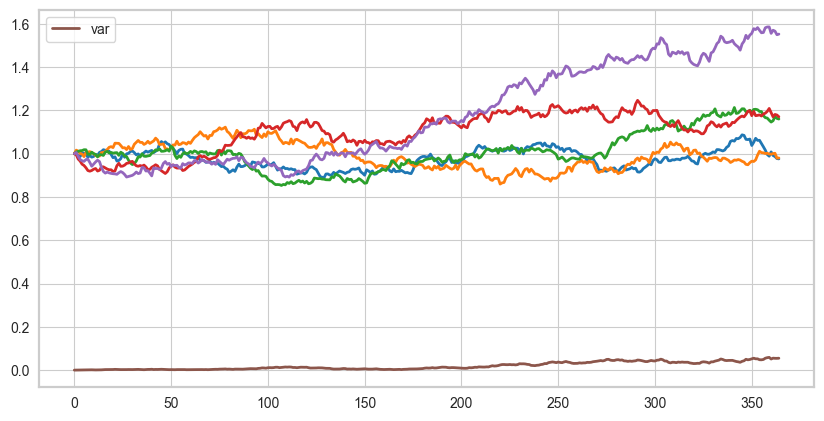

In [86]:
th.manual_seed(42)
paths = geometric_brownian_motion(5, maturity=365, volatility=0.2).T
for path in paths:
    plt.plot(path)
    
plt.plot(th.var(paths, axis=0), label='var')
plt.legend()

## 2. European option's price

In [5]:
def european_option_delta(log_moneyness, expiry, volatility):
    """
    log_moneyness : log ratio of money over execution price
    """
    s, t, v = map(th.as_tensor, (log_moneyness, expiry, volatility))
    normal = th.distributions.Normal(loc=th.tensor(0.), scale=th.tensor(1.))
    delta = normal.cdf((s.log()+(v**2/2)*t) / (v*th.sqrt(t)))

    return delta

## 3. Payoff

In [6]:
def european_option_payoff(prices: th.Tensor, strike=1.0) -> th.Tensor:
    return F.relu(prices[-1]-strike)

def lookback_option_payoff(prices_trajectory: th.Tensor, strike=1.03) -> th.Tensor:
    return F.relu(th.max(prices_trajectory, dim=0).values - strike)

## 4. Entropic Loss

In [7]:
def pnl_entropic_loss(pnl, aversion=1.0) -> th.Tensor:
    return -th.mean(-th.exp(-aversion*pnl), dim=-1)

# No Transaction Band Network

In [4]:
from Utils.tensors import create_module, clamp, to_numpy
from Utils.prices_torch import european_call_delta

class NoTransactionBandNet(nn.Module):
    def __init__(self, in_features=4, squash=False):
        super(NoTransactionBandNet, self).__init__()

        mlp = create_module(in_features, 2, [32, 32, 32, 32], activation_fn=nn.ReLU, squash_output=squash)
        self.mlp = nn.Sequential(*mlp)
        self.squash = squash

    def forward(self, obs, prev_hedge=None):
        """
        :param obs: (n_paths, 3)
        :param prev_hedge: (n_paths, 1)
        """
        log_moneyness, time_expiry, volatility = obs[:, 0], obs[:, 1], obs[:, 2]
        prev_hedge = obs[:, 3]      # [0, 1]
        no_cost_delta = european_call_delta(log_moneyness, time_expiry, volatility)   # [0, 1]

        band_width = self.mlp(obs)      # [-1, 1]
        lb = no_cost_delta - F.relu(band_width[:, 0])     # [-1, 1.a]
        ub = no_cost_delta + F.relu(band_width[:, 1])     # [-1, 1.a]

        if self.squash:
            prev_hedge_scaled = 2.0 * prev_hedge - 1.0
            hedge = 0.5*(clamp(prev_hedge_scaled, lb, ub)) + 0.5
        else:
            hedge = clamp(prev_hedge, lb, ub)

        return hedge

# P&L


In [9]:
def compute_pnl(hedging_model: nn.Module,
                n_assets,
                n_periods=30, volatility=0.2, dt=1/365,
                cost = 1e-3,
                recurrent: bool=True) -> th.Tensor:

    prices = geometric_brownian_motion(n_assets, n_periods, volatility=volatility, dt=dt)  # prices over all time, shape (n_steps, n_paths)
    hedge = th.zeros_like(prices[0])
    pnl = 0

    for i in range(prices.shape[0] - 1):
        prev_hedge = hedge

        log_moneyness = prices[i, :, None]  # obs_1, shape (n_paths, 1)
        time_expiry = th.full_like(log_moneyness, (n_periods - i)*dt)
        vol = th.full_like(log_moneyness, volatility)
        state = th.cat([log_moneyness, time_expiry, vol, th.unsqueeze(prev_hedge, -1)], dim=1)

        if recurrent:
            hedge = hedging_model(state, prev_hedge)
        else:
            hedge = hedging_model(state)

        # gain from price movement + loss from hedge movement
        pnl += hedge * (prices[i+1]-prices[i]) - cost * th.abs(hedge - prev_hedge) * prices[i]

    # buyer's option execution (so, it is loss for seller=(us))

    pnl -= european_option_payoff(prices)

    return pnl

## Training & Plotting

In [19]:
set_seed()
model_ntb = NoTransactionBandNet(in_features=4, squash=True)
model_ntb

NoTransactionBandNet(
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
    (9): Tanh()
  )
)

### Before Training

In [11]:
n_paths = 5000
epochs = 200

set_seed()
pnl_before = compute_pnl(model_ntb, n_paths, cost=1e-3)

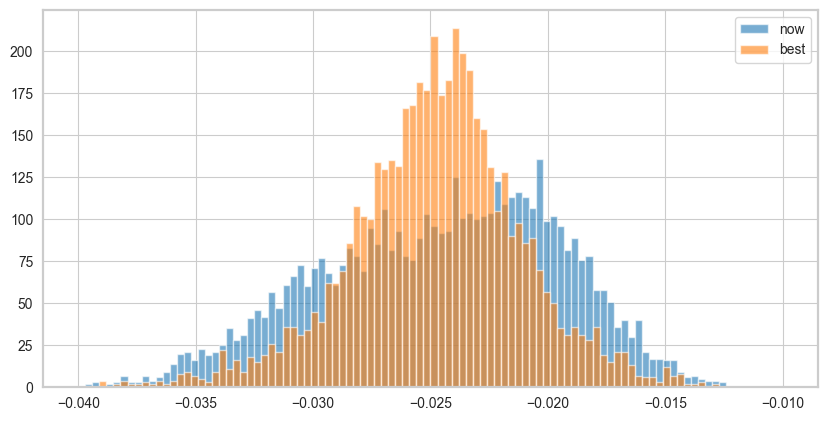

-0.02461026981472969
-0.02479863353073597


In [12]:
plt_kwargs = {'bins': 100,
              'range': (-0.04, -0.01),
              'alpha': 0.6}

plt.hist(to_numpy(pnl_before), **plt_kwargs, label='now')
plt.hist(np.load('best_pnl_before.npy'), **plt_kwargs, label='best')
plt.legend()
plt.show()

print(th.mean(pnl_before).item())
print(np.mean(np.load('best_pnl_before.npy')).item())

In [100]:
np.save('best_pnl_before_2', to_numpy(pnl_before))

In [16]:
# th.mean(pnl_before)

tensor(-0.0248, grad_fn=<MeanBackward0>)

# Learn

In [15]:
from tqdm import tqdm

def fit(model: nn.Module,
        n_assets: int,
        steps: int,
        recurrent=False) ->list:

    optimizer = th.optim.Adam(model.parameters())

    loss_history = []
    progress = tqdm(range(steps))
    for epoch in progress:
        optimizer.zero_grad()
        pnl = compute_pnl(model, n_assets, recurrent=recurrent)
        loss = -th.mean(pnl)

        loss.backward()
        optimizer.step()

        progress.desc = f'Loss={loss:.5f}'
        loss_history.append(loss.item())

    return loss_history

In [16]:
losses = fit(model_ntb, n_paths, epochs)

Loss=0.02256: 100%|██████████| 200/200 [00:36<00:00,  5.52it/s]


### Train Benchmark

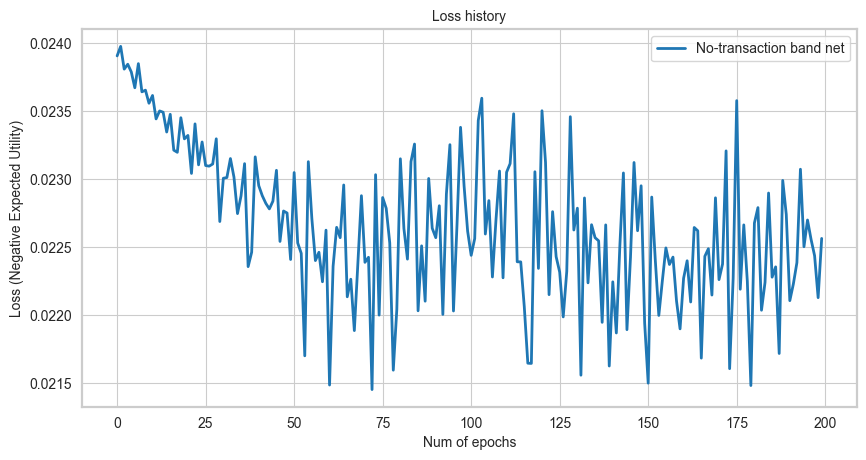

In [17]:
plt.plot(losses, label='No-transaction band net')
plt.xlabel('Num of epochs')
plt.ylabel('Loss (Negative Expected Utility)')
plt.title('Loss history')
plt.legend(loc='upper right')
plt.show()

In [18]:
set_seed()
pnl_after = compute_pnl(model_ntb, n_paths, cost=1e-3, recurrent=False)

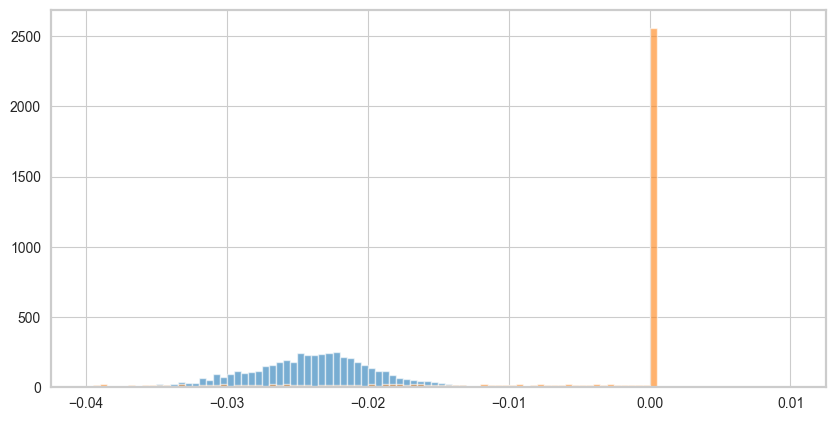

In [19]:
plt_kwargs['range'] = (-0.04, 0.01)
plt.hist(to_numpy(pnl_before), **plt_kwargs)
plt.hist(to_numpy(pnl_after), **plt_kwargs)
plt.show()

In [102]:
np.save('best_pnl_after_2', to_numpy(pnl_after))

In [95]:
th.mean(pnl_after.detach()).item()

-0.02268713153898716

In [101]:
np.mean(np.load('best_pnl_after_2.npy'))

FileNotFoundError: [Errno 2] No such file or directory: 'best_pnl_after_2.npy'

# Env

In [20]:
class BsMarket2:
    def __init__(self, n_assets, cost, n_periods=30, volatility=0.2, dt=1/365, payoff_coeff=1.0):
        self.n_assets = n_assets
        self.cost = cost
        self.n_periods = n_periods
        self.volatility = volatility
        self.dt = dt
        self.payoff_coeff = payoff_coeff

        self.prices = None
        self.option_prices = None
        self.hedge = None

        self.now = 0

        self.reset()

    def reset(self):
        self.prices = geometric_brownian_motion(self.n_assets,
                                                self.n_periods,
                                                self.dt,
                                                0.0,
                                                self.volatility)

        self.option_prices = self.get_call_option_prices()

        # self.hedge = th.zeros(self.n_assets)
        self.hedge = th.zeros(self.n_assets) + 0.5
        self.now = 0

        return self.get_obs()

    def get_call_option_prices(self):
        expiry = th.linspace(self.n_periods*self.dt, 0, self.n_periods)[:-1, None]
        head = (th.log(self.prices[:-1]) + (0.5 * self.volatility**2) * expiry)
        tail = self.volatility * th.sqrt(expiry)
        d1 = head / tail
        d2 = d1 - tail
        normal = th.distributions.Normal(loc=th.tensor(0.), scale=th.tensor(1.))

        return self.prices[:-1] * normal.cdf(d1) - 1.0 * normal.cdf(d2)

    def get_obs(self, i=None):
        if i is None:
            i = self.now

        moneyness = self.prices[i, :, None]
        expiry = th.full_like(moneyness, (self.n_periods - i)*self.dt)
        volatility = th.full_like(moneyness, self.volatility)
        prev_hedge = self.hedge[:, None]

        obs = th.cat([moneyness, expiry, volatility, prev_hedge], dim=1)

        return obs

    def pnl_step(self, action):
        assert th.all(action >= 0.0) and th.all(action <= 1.0), print(th.min(action), th.max(action))
        i = self.now
        reward = action * (self.prices[i+1]-self.prices[i]) - self.cost * th.abs(action - self.hedge) * self.prices[i]

        self.now += 1
        self.hedge = action.detach()
        done = self.now == self.n_periods - 1

        if done:
            reward -= self.payoff_coeff * (F.relu(self.prices[-1] - 1))
        else:
            reward -= self.payoff_coeff * (self.option_prices[i+1] - self.option_prices[i])

        return self.get_obs(), reward, done, {}


## P&L 2

In [11]:
def compute_pnl2(hedging_model: nn.Module,
                env,
                recurrent: bool=False) -> th.Tensor:

    total_pnl = 0
    obs = env.reset()
    done, info = False, {}
    while not done:
        if recurrent:
            action = hedging_model(obs, env.hedge)
        else:
            action = hedging_model(obs)
        obs, reward, done, info = env.pnl_step(action)
        total_pnl += reward

    return total_pnl

def pnl_eval(model, env):
    total_pnl = 0
    obs = env.reset()
    done, info = False, {}
    while not done:
        action = model(obs)
        obs, reward, done ,info = env.step(action)
        total_pnl += info['raw_reward']

    return to_numpy(total_pnl)

def get_reward(pnl, coeff=0.2):
    # print(f'mean: {pnl.mean():.4f}\t\tstd:{pnl.std():.4f}')
    return pnl.mean() - coeff * pnl.std()

In [7]:
from Env.env_torch import BSMarketTorch

n_paths = 5000
epochs = 200

set_seed()
model_ntb = NoTransactionBandNet(in_features=4, squash=True)

set_seed()
env = BSMarketTorch(n_assets=n_paths, cost=1e-3, payoff_coeff=0.0)

env 'BSMarket was created!


In [13]:
with th.no_grad():
    pnl_before = pnl_eval(model_ntb, env)

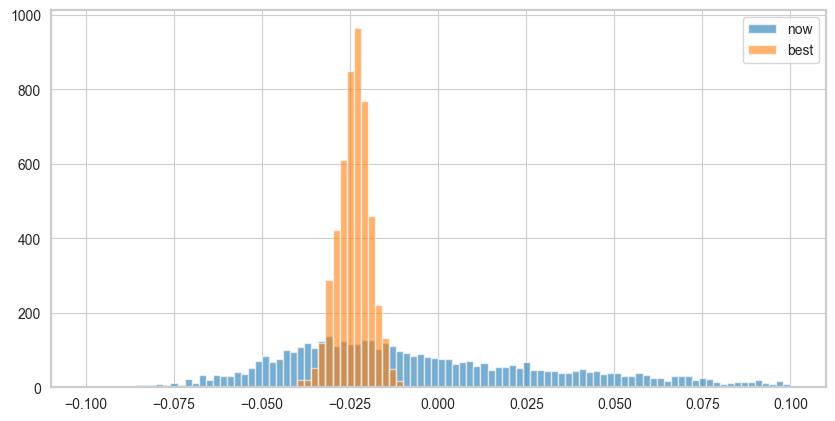

-0.010756678692996503 0.043368492
-0.024909551348537208 0.004581665


In [14]:
plt_kwargs = {'bins': 100,
              'range': (-0.1, 0.1),
              'alpha': 0.6}

plt.hist(pnl_before, **plt_kwargs, label='now')
plt.hist(np.load('best_pnl_before_2.npy'), **plt_kwargs, label='best')
plt.legend()
plt.show()

print(get_reward(pnl_before), pnl_before.std())
print(get_reward(np.load('best_pnl_before_2.npy')), np.load('best_pnl_before_2.npy').std())

## Learn 2

In [15]:
from tqdm import tqdm

def fit2(model: nn.Module,
         env,
        steps: int,
        recurrent=False) ->list:

    optimizer = th.optim.Adam(model.parameters())

    loss_history = []
    progress = tqdm(range(steps))
    for epoch in progress:
        optimizer.zero_grad()
        pnl = compute_pnl2(model, env, recurrent=recurrent)
        # loss = -th.mean(pnl) + 0.2 * th.std(pnl)
        loss = -pnl
        # loss = pnl_entropic_loss(pnl)

        loss.backward()
        optimizer.step()

        progress.desc = f'Loss={loss:.5f}'
        loss_history.append(loss.item())

    return loss_history

In [16]:
losses = fit2(model_ntb, env, 150)

Loss=0.00032: 100%|██████████| 150/150 [00:48<00:00,  3.10it/s]


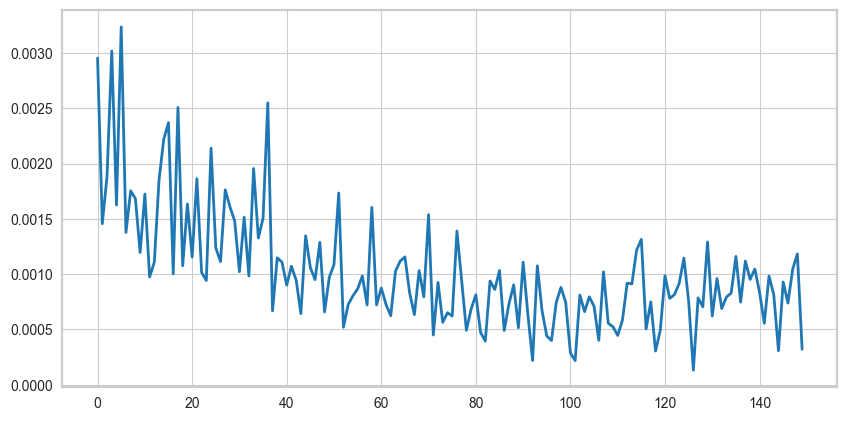

In [17]:
plt.plot(losses)

In [18]:
set_seed()
pnl_after = pnl_eval(model_ntb, env)

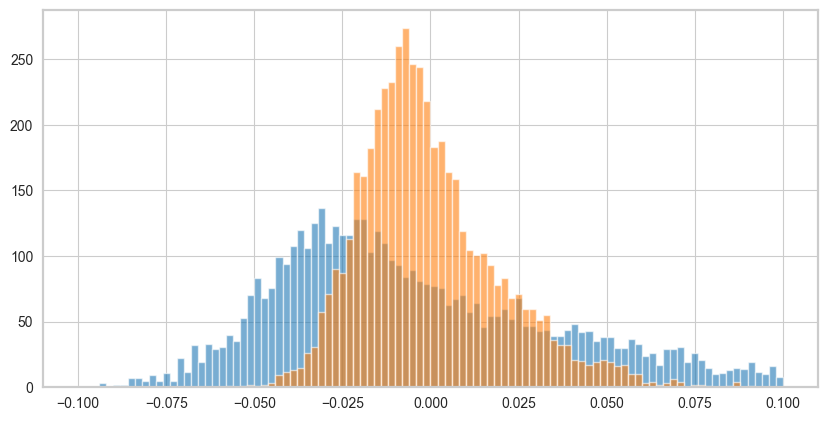

-0.010756678692996503
-0.004585400491487235


In [19]:
plt_kwargs['range'] = (-0.1, 0.1)
plt.hist(pnl_before, **plt_kwargs)
plt.hist(pnl_after, **plt_kwargs)
plt.show()

print(get_reward(pnl_before))
print(get_reward(pnl_after))

In [43]:
np.save('pnl_env_before_squash', pnl_before)
np.save('pnl_env_after_squash', pnl_after)

위 그래프는 BSMarketTorch env, NoTransactionBand로 수행한 결과입니다.
loss = -reward 입니다.

# Env 2

In [9]:
from Env.env_torch import BSMarketTorch

n_paths = 5000
epochs = 200

env = BSMarketTorch(n_assets=n_paths, cost=1e-3, payoff_coeff=0.0)

env 'BSMarket was created!


In [10]:
def pnl_eval(env, model):
    obs = env.reset()
    reward, done, info = 0, False, {}
    total_raw_reward = 0
    while not done:
        action = model(obs)
        obs, reward, done, info = env.step(action)
        total_raw_reward += info['raw_reward']

    return to_numpy(total_raw_reward)

In [14]:
set_seed()
model_ntb = NoTransactionBandNet(in_features=4, squash=True)

In [15]:
with th.no_grad():
    pnl_before = pnl_eval(env, model_ntb)

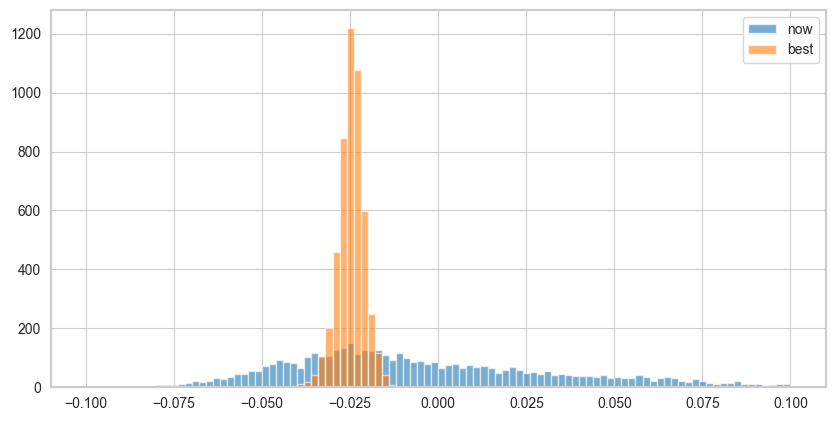

-0.0016311595
-0.02479863353073597


In [17]:
plt_kwargs = {'bins': 100,
              'range': (-0.1, 0.1),
              'alpha': 0.6}

plt.hist(pnl_before, **plt_kwargs, label='now')
plt.hist(np.load('best_pnl_before.npy'), **plt_kwargs, label='best')
plt.legend()
plt.show()

print(np.mean(pnl_before))
print(np.mean(np.load('best_pnl_before.npy')).item())

In [22]:
losses = fit2(model_ntb, env, 150)

Loss=0.00104: 100%|██████████| 150/150 [00:54<00:00,  2.76it/s]


In [23]:
with th.no_grad():
    pnl_after = pnl_eval(env, model_ntb)

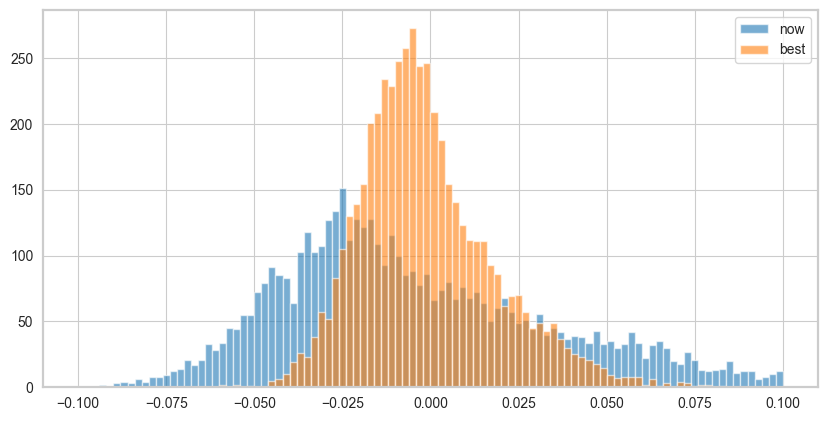

-0.010175860044546426
-0.0050158812664449215


In [24]:
plt.hist(pnl_before, **plt_kwargs, label='now')
plt.hist(pnl_after, **plt_kwargs, label='best')
plt.legend()
plt.show()

print(get_reward(pnl_before))
print(get_reward(pnl_after))

# 2

In [2]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sb
import matplotlib

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

def set_seed(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    # os.environ["PYTHONHASHSEED"] = str(seed) # os
    th.manual_seed(seed)
    # th.cuda.manual_seed(seed)
    # th.backends.cudnn.deterministic = True
    # th.backends.cudnn.benchmark = False

In [33]:
from ntb import NoTransactionBand

model_kwargs = {'features_in': 3,
                'net_arch': [32, 32, 32, 32],
                'activation_fn': nn.ReLU,
                'net_kwargs': None,
                'squash': False}

set_seed()
model = NoTransactionBand(**model_kwargs)
model

NoTransactionBand(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
    (9): Tanh()
  )
)

In [3]:
def pnl_entropic_loss(pnl, aversion=1.0) -> th.Tensor:
    return -th.mean(-th.exp(-aversion*pnl), dim=-1)

In [7]:
from Env.env_torch import BSMarketTorch

env_kwargs = {'n_assets': 5000,
              'cost': 1e-3,
              'payoff_coeff': 0.0}

set_seed()
env = BSMarketTorch(**env_kwargs)

env 'BSMarket was created!


In [41]:
from Utils.prices_torch import european_option_payoff

def compute_pnl(hedging_model: nn.Module,
                env,
                cost = 1e-3,
                n_periods = 30,
                volatility = 0.2,
                dt = 1/365,
                recurrent: bool=True) -> th.Tensor:

    prices = env.underlying_prices.clone()
    hedge = th.zeros_like(prices[0])
    pnl = 0

    for i in range(prices.shape[0] - 1):
        log_moneyness = prices[i, :, None]
        expiry = th.full_like(log_moneyness, (n_periods - i)*dt)
        vol = th.full_like(log_moneyness, volatility)
        state = th.cat([log_moneyness, expiry, vol], dim=1)

        prev_hedge = hedge
        if recurrent:
            hedge = hedging_model(state, prev_hedge)
        else:
            hedge = hedging_model(state)

        # gain from price movement + loss from hedge movement
        pnl += hedge * (prices[i+1]-prices[i]) - cost * th.abs(hedge - prev_hedge) * prices[i]

    # buyer's option execution (so, it is loss for seller=(us))

    pnl -= european_option_payoff(prices)

    return pnl

def compute_pnl2(model: nn.Module,
                 env):

    pnl = 0
    obs = env.reset()
    done, info = False, {}
    while not done:
        actions = model(obs)
        obs, reward, done, info = env.step(actions)
        pnl += reward

    return pnl

def pnl_eval(model, env):
    pnl = 0
    obs = env.reset()
    done, info = False, {}
    while not done:
        actions = model(obs)
        obs, reward, done, info = env.step(actions)
        pnl += info['raw_reward']

    return pnl

In [31]:
from tqdm import tqdm

def fit(hedging_model: nn.Module,
        env,
        steps: int,
        recurrent=True) ->list:

    optimizer = th.optim.Adam(hedging_model.parameters())

    loss_history = []
    progress = tqdm(range(steps))
    for epoch in progress:
        optimizer.zero_grad()
        env.reset()
        pnl = compute_pnl(hedging_model, env, recurrent)
        loss = pnl_entropic_loss(pnl)

        loss.backward()
        optimizer.step()

        progress.desc = f'Loss={loss:.5f}'
        loss_history.append(loss.item())

    return loss_history


def fit2(model: nn.Module, env, steps):
    optimizer = th.optim.Adam(model.parameters())

    loss_history = []
    progress = tqdm(range(steps))
    for epoch in progress:
        optimizer.zero_grad()
        env.reset()
        pnl = compute_pnl2(model, env)
        loss = -pnl

        loss.backward()
        optimizer.step()

        progress.desc = f'Loss={loss:.5f}'
        loss_history.append(loss.item())

    return loss_history

In [34]:
set_seed()
pnl_before = compute_pnl2(model, env)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5000x4 and 3x32)

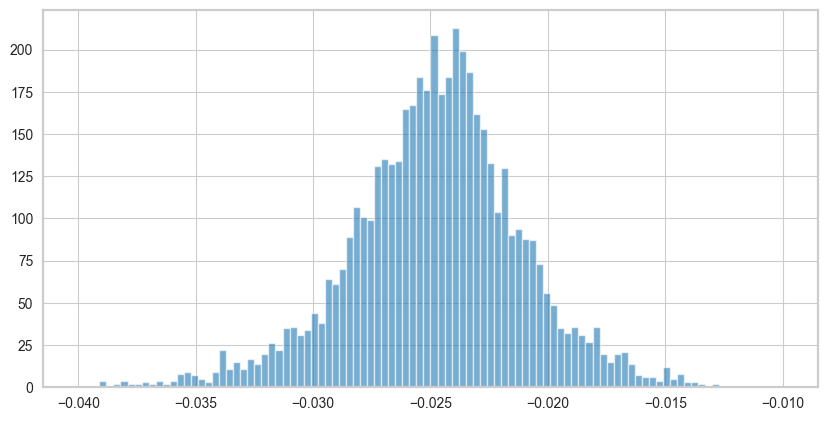

In [17]:
from Utils.tensors import to_numpy

plt_kwargs = {'bins':100,
              'range': (-0.04, -0.01),
              'alpha': 0.6}

plt.hist(to_numpy(pnl_before), **plt_kwargs)
plt.show()

In [25]:
losses = fit(model, env, steps=200)

Loss=1.02283: 100%|██████████| 200/200 [00:44<00:00,  4.50it/s]


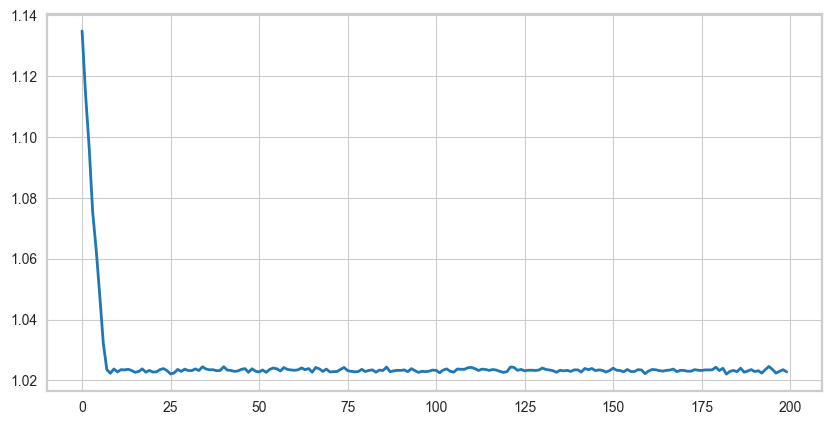

In [26]:
plt.plot(losses)
plt.show()

In [27]:
pnl_after = compute_pnl(model, env, recurrent=True)

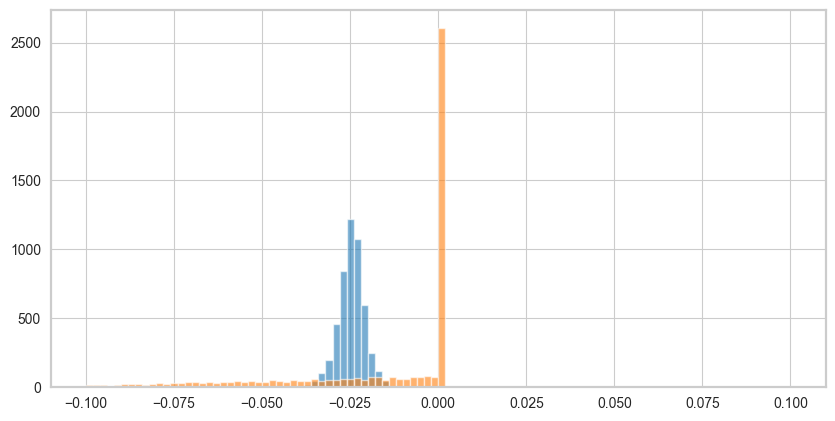

In [29]:
plt_kwargs['range'] = (-0.1, 0.1)
plt.hist(to_numpy(pnl_before), **plt_kwargs)
plt.hist(to_numpy(pnl_after), **plt_kwargs)
plt.show()

In [35]:
model_kwargs = {'features_in': 4,
                'net_arch': [32, 32, 32, 32],
                'activation_fn': nn.ReLU,
                'net_kwargs': None,
                'squash': True}

set_seed()
model = NoTransactionBand(**model_kwargs)
model

NoTransactionBand(
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
    (9): Tanh()
  )
)

In [36]:
env_kwargs = {'n_assets': 5000,
              'cost': 1e-3,
              'payoff_coeff': 0.0}

set_seed()
env = BSMarketTorch(**env_kwargs)

env 'BSMarket was created!


In [42]:
set_seed()
pnl_before = pnl_eval(model, env)

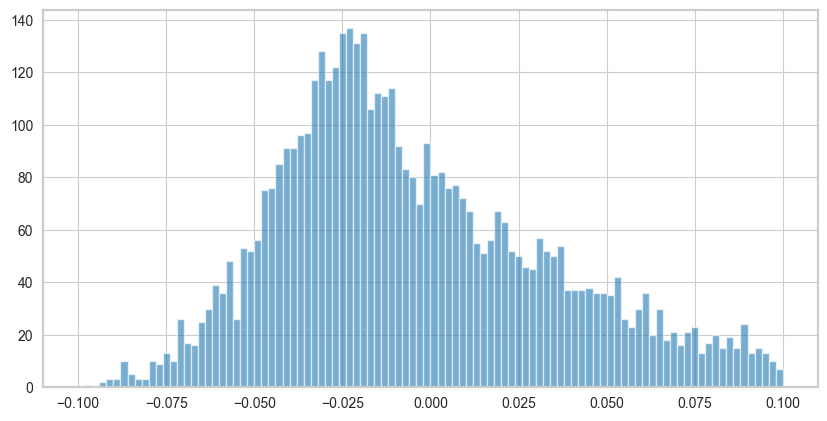

In [44]:
plt.hist(pnl_before, **plt_kwargs)
plt.show()

In [45]:
losses = fit2(model, env, steps=150)

Loss=0.00078: 100%|██████████| 150/150 [00:37<00:00,  4.02it/s]


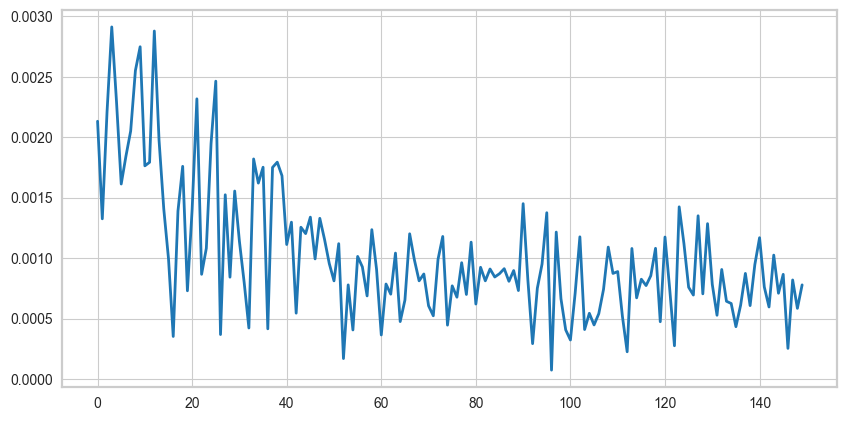

In [47]:
plt.plot(losses)
plt.show()

In [48]:
pnl_after= pnl_eval(model, env)

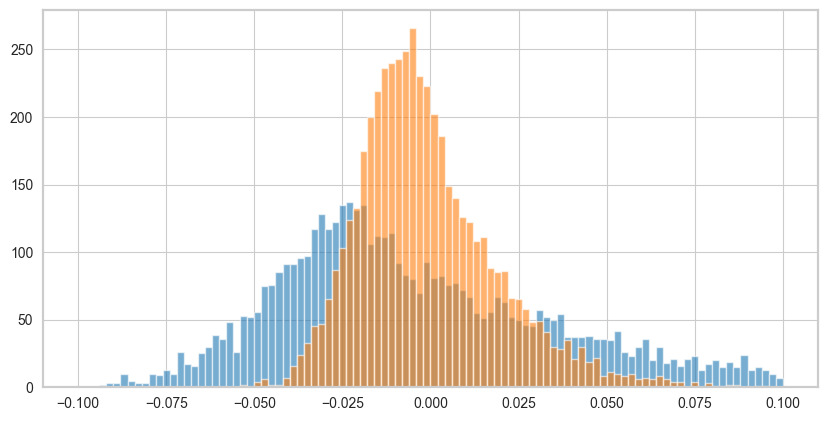

In [49]:
plt.hist(pnl_before, **plt_kwargs)
plt.hist(pnl_after, **plt_kwargs)
plt.show()

In [3]:
from Env.env_torch import BSMarketTorch
from Env.env import BSMarket

env_kwargs = {'n_assets': 5000,
              'cost': 1e-3,
              'payoff_coeff': 0.0}

set_seed()
env_th = BSMarketTorch(**env_kwargs)

set_seed()
env_np = BSMarket(**env_kwargs)

env 'BSMarket was created!
env 'BSMarket was created!


In [8]:
env_th.option_prices[10][:5]

tensor([0.0010, 0.0215, 0.0487, 0.0105, 0.0142])

In [7]:
env_np.option_prices[10][:5]

array([0.00101208, 0.02151274, 0.04865232, 0.01046865, 0.01420829])